In [1]:
import pandas as pd

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding
from tensorflow.keras import layers
from tensorflow import keras

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import matplotlib.pyplot as plt

In [2]:
df = pd.read_json("/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json", lines=True)

In [3]:
# The number of sarcastics and non-sarcastics are almost similar 
df['is_sarcastic'].value_counts()

0    14985
1    13634
Name: is_sarcastic, dtype: int64

In [4]:
y = df["is_sarcastic"].values

X = df["headline"].values

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.2)

In [6]:
num_words = 10000
max_length = 20
trunc_type='post'
padding_type='post'
oov_tok = '<OOV>'

In [7]:
tokenizer = Tokenizer(num_words=num_words,
                      oov_token='oov_tok')

In [8]:
tokenizer.fit_on_texts(X_train)

In [9]:
word_ind = tokenizer.word_index

In [10]:
training_seq = tokenizer.texts_to_sequences(X_train)

In [11]:
training_padded = pad_sequences(training_seq, padding='post', truncating='post', maxlen=max_length)

In [12]:
test_seq = tokenizer.texts_to_sequences(X_test)

In [13]:
test_padded = pad_sequences(test_seq, padding=padding_type, truncating=trunc_type, maxlen=max_length)

In [14]:
model = keras.models.Sequential([
    layers.Embedding(input_dim=num_words,
                     output_dim=128,
                     input_length=max_length),
    layers.Bidirectional(layers.LSTM(50), ),
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

2022-05-14 14:42:49.839729: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-14 14:42:49.937697: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-14 14:42:49.938517: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-14 14:42:49.939717: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 128)           1280000   
_________________________________________________________________
bidirectional (Bidirectional (None, 100)               71600     
_________________________________________________________________
dense (Dense)                (None, 64)                6464      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 1,358,129
Trainable params: 1,358,129
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [17]:
early_stopping = EarlyStopping(patience=5, monitor='val_loss')

reduce_lr = ReduceLROnPlateau(monitor='val_loss', min_lr=0.001,
                        patience=5, mode='min',
                        verbose=1)

model_checkpoint = ModelCheckpoint(monitor='val_loss', 
                             filepath='model-best-kaggle-tl.h5', 
                             save_best_only=True)

callbacks = [
    early_stopping,
    reduce_lr,
    model_checkpoint
]

In [18]:
history = model.fit(training_padded, y_train, validation_data=(test_padded, y_test), epochs=30, callbacks=callbacks)

2022-05-14 14:42:53.401592: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2022-05-14 14:42:57.414484: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


716/716 [==============================] - 11s 8ms/step - loss: 0.3792 - accuracy: 0.8215 - val_loss: 0.3232 - val_accuracy: 0.8567
Epoch 2/30
716/716 [==============================] - 5s 8ms/step - loss: 0.2494 - accuracy: 0.8981 - val_loss: 0.2914 - val_accuracy: 0.8742
Epoch 3/30
716/716 [==============================] - 5s 8ms/step - loss: 0.2065 - accuracy: 0.9181 - val_loss: 0.2991 - val_accuracy: 0.8753
Epoch 4/30
716/716 [==============================] - 5s 8ms/step - loss: 0.1801 - accuracy: 0.9305 - val_loss: 0.2987 - val_accuracy: 0.8770
Epoch 5/30
716/716 [==============================] - 6s 8ms/step - loss: 0.1541 - accuracy: 0.9406 - val_loss: 0.3261 - val_accuracy: 0.8744
Epoch 6/30
716/716 [==============================] - 5s 8ms/step - loss: 0.1300 - accuracy: 0.9503 - val_loss: 0.3698 - val_accuracy: 0.8674
Epoch 7/30
716/716 [==============================] - 5s 7ms/step - loss: 0.1111 - accuracy: 0.9585 - val_loss: 0.3825 - val_accuracy: 0.8636


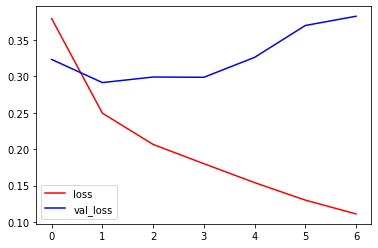

In [19]:
plt.plot(history.history['loss'], 'r-', label='loss')
plt.plot(history.history['val_loss'], 'b-', label='val_loss')
plt.legend()
plt.show()

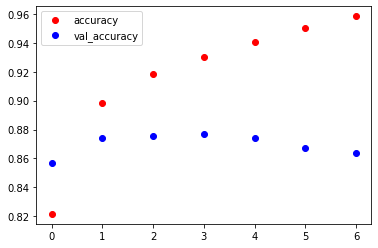

In [20]:
plt.plot(history.history['accuracy'], 'ro', label='accuracy')
plt.plot(history.history['val_accuracy'], 'bo', label='val_accuracy')
plt.legend()
plt.show()

In [21]:
my_model = tf.keras.models.load_model('/kaggle/working/model-best-kaggle-tl.h5')

In [22]:
loss, val_acc = my_model.evaluate(test_padded, y_test)

179/179 [==============================] - 1s 4ms/step - loss: 0.2914 - accuracy: 0.8742


In [23]:
print(f"The validation accuracy of my model is {100 * val_acc:.2f}%.")

The validation accuracy of my model is 87.42%.
